In [3]:
from __future__ import division
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import scipy
from sklearn.model_selection import cross_validate
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.naive_bayes import BernoulliNB
import sklearn
from multiprocessing import Process, Queue
import ctypes
from heapq import nlargest 
from tqdm import tqdm
from functools import reduce
import zlib
from nltk.corpus import stopwords
import functools
from bs4 import BeautifulSoup, Comment
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import base64
import csv
import gzip
import zlib
import pymorphy2
import re
import numpy as np
from collections import namedtuple
from bs4 import BeautifulSoup
import logging
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import lightgbm

In [4]:
TRACE_NUM = 1000
#reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [5]:
!pip install unicode

In [6]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи дополнительных библиотек

In [7]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [8]:

html2text = html2text_bs

#### Методы для токенизации текста

In [9]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form          
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [10]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

In [11]:
stopwords_english = set(stopwords.words('english') )
stopwords_russian = set(stopwords.words('russian') )
stopwords = list(stopwords_russian) + list(stopwords_english)
all_stopwords = set(stopwords)


In [211]:
spam_words = {}

In [11]:
def work(html_data):
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        html_data = ""
    soup = BeautifulSoup(html_data, "html.parser")
    words = pymorphy_tokenizer(soup.get_text())
    word = []
    for k in words:
        if k not in all_stopwords:
            word.append(k) 
    wordi, counts = np.unique(np.array(word), return_counts = True)
    for i in range(len(wordi)):     
        if spam_words.get(wordi[i], -1) == -1:
            spam_words[wordi[i]] = 0
        else:
            spam_words[wordi[i]] += counts[i]
    return

In [12]:
EightHighest ={'скачать': 61962,
'порно': 57658,
'секс': 31950,
'фото': 30431,
'0':26098,
'бесплатно': 22183,
'знакомство': 19131,
'драйвер': 18748,
'http': 18051} #по результатам работы функции work


In [13]:
corpus_doc = []
corpus_word = []
corpus_dat = []
all_words = {}
j = 0
doc_ids = {}
m = 0

In [14]:
def dictionary(url_id,html_data):#парсим ВЕСЬ текст
    global j
    global m
    doc_ids[url_id] = m
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        html_data = ""
    
    soup = BeautifulSoup(html_data, "html.parser")
    words = pymorphy_tokenizer(soup.get_text())
    word = []
    for k in words:
        if k not in all_stopwords:
            word.append(k.lower())

    loc_set = set()
    for i in range(len(word)):
        if all_words.get(word[i], -1) == -1:
            all_words[word[i]] = j
            j += 1
        if word[i] not in loc_set:
            corpus_doc.append(m)
            corpus_word.append(all_words.get(word[i]))
            corpus_dat.append(word.count(word[i]))
            loc_set.add(word[i])
    m += 1
    return

In [15]:
corpus_doc1 = []
corpus_word1 = []
corpus_dat1 = []
all_words1 = {}
j1 = 0
doc_ids1 = {}
m1 = 0

In [16]:
def dictionary_u(url_id,url): #парсим url
    global m1
    global j1
    doc_ids1[url_id] = m1

    word = []
    url1 = urlparse(url)
    site = url1.netloc.split('.')   
    for k in site:
        if not k.isdigit() and  k != '' and k not in all_stopwords:
            word.append(k.lower())
    path = url1.path.split('/')
    for a in path:
        a = a.split('-')
        for b in a:
            b = b.split('_')
            for c in b:
                if  not c.isdigit() and c != '' and c not in all_stopwords:
                    word.append(c.lower())
    loc_set = set()
    for i in range(len(word)):
        if all_words1.get(word[i], -1) == -1:
            all_words1[word[i]] = j
            j1 += 1
        if word[i] not in loc_set:
            corpus_doc1.append(m1)
            corpus_word1.append(all_words.get(word[i]))
            corpus_dat1.append(word.count(word[i]))
            loc_set.add(word[i])
    m1 += 1
    return

In [17]:
b = 0

In [18]:
def write(html_data): #парсим ВИДИМЫЙ текст
    global b
    soup = BeautifulSoup(html_data, "html.parser")
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    words = pymorphy_tokenizer(soup.get_text()) if soup is not None else []
    text = ''
    for k in words:
        if k not in all_stopwords:
            text += (' ' + k.lower())
    with open('title_train/doc'+str(b) , 'w') as fout:
        fout.write(text)
        b += 1

In [19]:
def calc_features(doc_id, url, html_data):
    zipp = zlib.compress(html_data)
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        html_data = ""
    dot_html = 0 if url[-5:].find("html")== -1 else 1
    url_len = len(url)
    dot = url.count(".")
  
    soup = BeautifulSoup(html_data, "html.parser")
    script_num = len(soup.find_all('script'))
    imgs_num = len(soup.find_all('img'))
    css_files = len(soup.findAll('link',{'rel':'stylesheet'}))
    objects = len(soup.find_all('object'))
    hid = len(soup.select( '[style~="visibility:hidden"]' )) + len( soup.select( '[style~="display:none"]'))
    span = len(soup.find_all('span'))
    div = len(soup.find_all('div'))
    [s.extract() for s in soup(['script', 'style'])]
    title = soup.find('title')
    if title is not None: title = title.get_text()
    else: title = " "
    
    words = soup.get_text()
    words_num = len(words.split())  
    avg_word_len = float(functools.reduce(lambda prev, cur: prev + len(cur), words, 0)) / float(words_num) if words_num != 0 else 0.0
    
    title_words_num = len(title.split())
    title_array = []
    for k in pymorphy_tokenizer(title):
        title_array.append(k)
    title_spamness = 0
    for cur_word in  EightHighest:
        title_spamness += title_array.count(cur_word) * EightHighest[cur_word]
    anchor = soup.find_all('a')
    anchor_num = len(anchor)

    anchor_words_num = len(functools.reduce(lambda prev, cur: prev + cur.text, anchor, "").split())
    compression_level = float(len(zipp)) / float(len(html_data)) if len(html_data) != 0 else 0
   
    strong_num = len(soup.find_all('strong'))
    b_num = len(soup.find_all('b'))
    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])] 
    visible_words = len(soup.get_text().split())
    percent = float(visible_words) / float(words_num) if words_num != 0 else 0
    word_array_normalize = []

    for k in  pymorphy_tokenizer(words):
       
        word_array_normalize.append(k)
        
    percent_same = float(len(set(word_array_normalize))) / float(words_num) if words_num != 0 else 0
    signif = float(np.max(np.unique(np.array(words.split()), return_counts = True)[1])) / float(words_num) if words_num != 0 else 0

    spamness = 0
    for cur_word in  EightHighest.keys():
        spamness += word_array_normalize.count(cur_word) * EightHighest[cur_word]
    return [
            script_num, 
            css_files, 
            objects,
            hid, 
            span, 
            div,
            title_spamness,
            signif,
            words_num, 
            avg_word_len, 
            title_words_num, 
            anchor_words_num, 
            compression_level, 
            script_num, 
            anchor_num,
            percent,
            visible_words, 
            imgs_num, 
            strong_num + b_num,  
            spamness,
            url_len,
            dot,
            dot_html,
            percent_same
           ] 

In [22]:

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().decode('utf-8').split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            dictionary(url_id, html_data)
            html_data = base64.b64decode(pageInb64)
            write(html_data)
            dictionary_u(url_id,url)
            features = calc_features_f(url_id, url, html_data)
        
            yield DocItem(url_id, mark, url, features)   
            pass
        trace(i, 1)  

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [23]:
%%time

TRAIN_DATA_FILE = 'kaggle_train_data_tab_new.csv.gz'
train_docs=list(load_csv(TRAIN_DATA_FILE, calc_features))

22:43:08 INFO:Complete items 00000
22:44:36 INFO:Complete items 01000
22:45:41 INFO:Complete items 02000
22:46:48 INFO:Complete items 03000
22:48:00 INFO:Complete items 04000
22:49:21 INFO:Complete items 05000
22:50:43 INFO:Complete items 06000
22:51:52 INFO:Complete items 07000
22:51:54 INFO:Complete items 07043


CPU times: user 8min 44s, sys: 894 ms, total: 8min 45s
Wall time: 8min 45s


In [24]:
X_train = []
Y_train = []
for doc_num, doc in enumerate(train_docs):
    X_train.append(doc.features)
    Y_train.append(doc.is_spam)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [25]:
titles = ['script_num', 
            'css_files', 
            'objects',
            'hid', 
            'span', 
            'div',
            'title_spamness',
            'signif',
            'words_num', 
            'avg_word_len', 
            'title_words_num', 
            'anchor_words_num', 
            'compression_level', 
            'script_num', 
            'anchor_num',
            'percent',
            'visible_words', 
            'imgs_num', 
            'strong_num + b_num',  
            'spamness',
            'url_len',
            'dot',
            'dot_html',
            'percent_same']

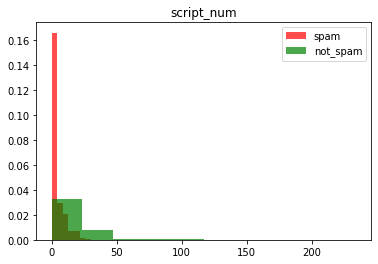

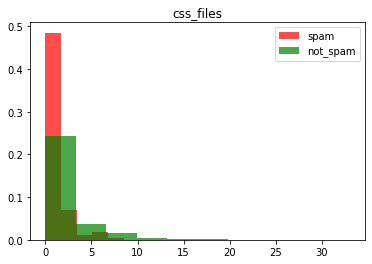

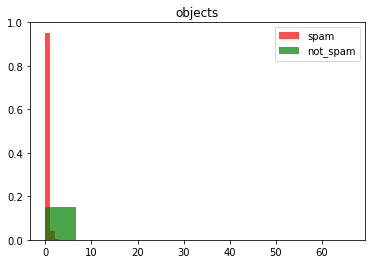

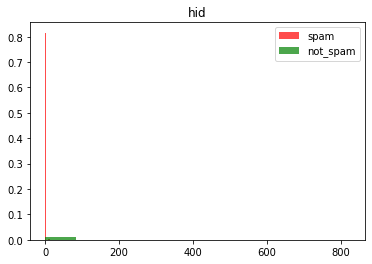

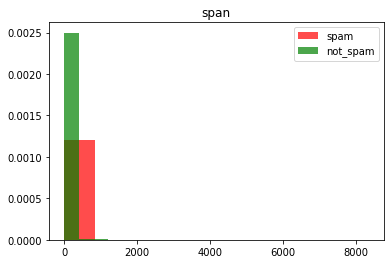

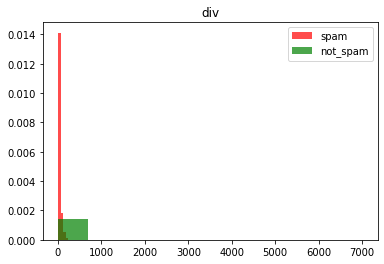

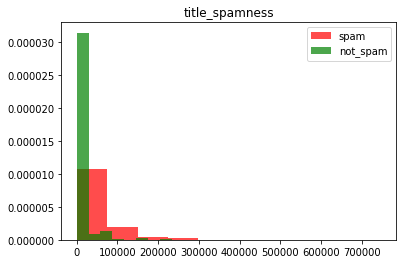

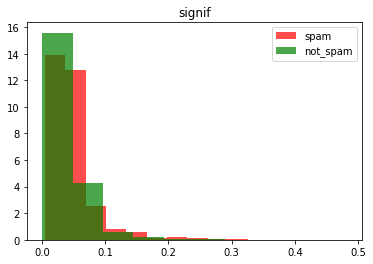

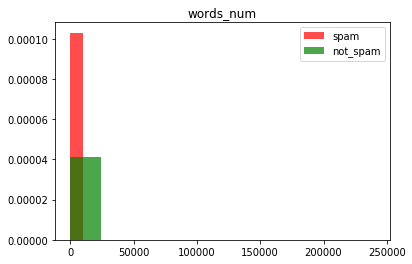

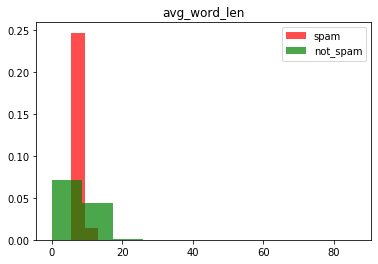

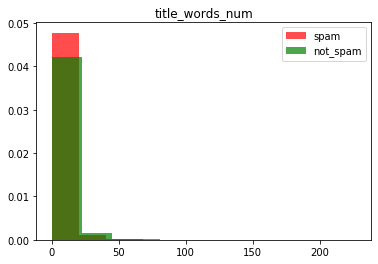

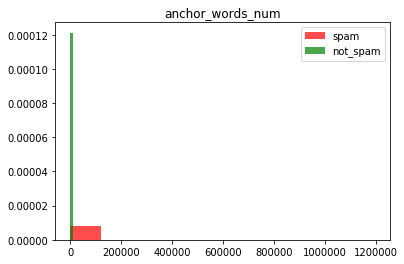

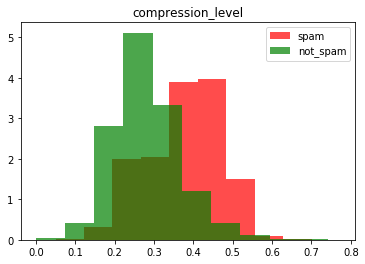

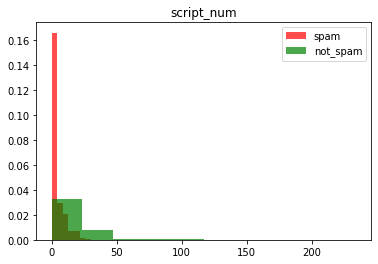

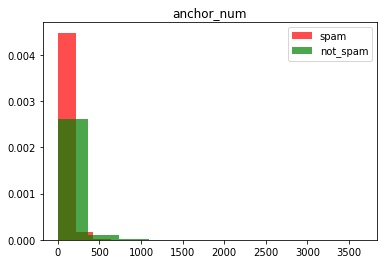

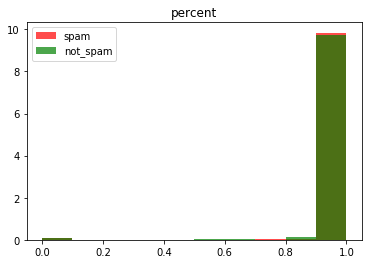

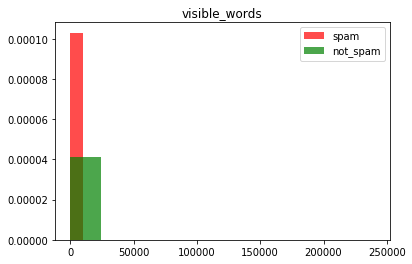

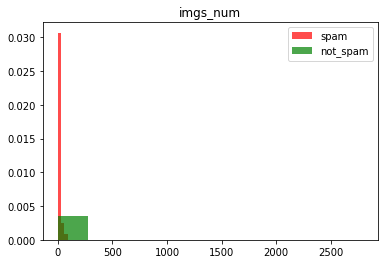

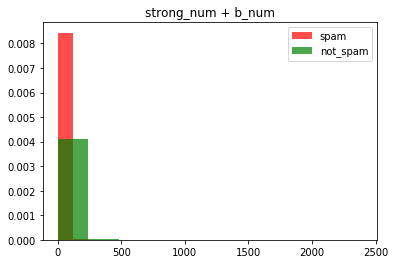

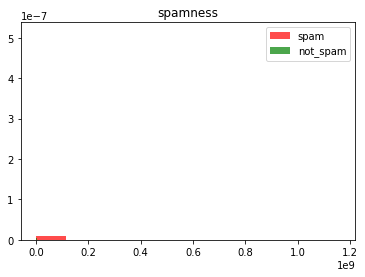

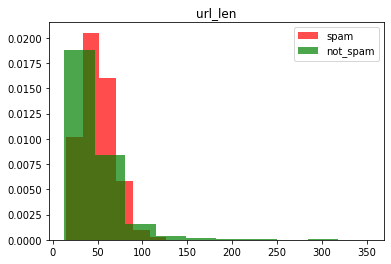

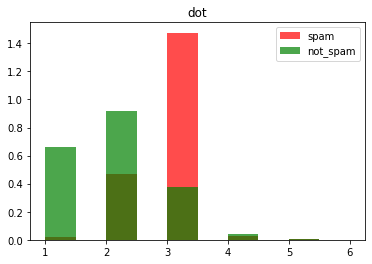

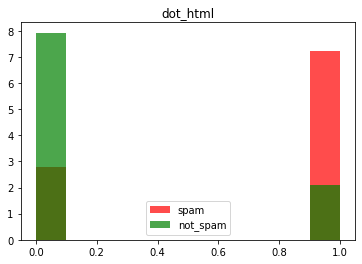

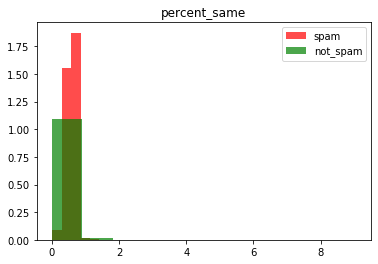

In [28]:
for i in range(len(doc.features)):
    spam = [doc.features[i] for doc in train_docs if doc[1] == True]
    not_spam = [doc.features[i] for doc in train_docs if doc[1] == False]
    plt.hist(spam, color='red', density=True, alpha=0.7, label='spam')
    plt.hist(not_spam, color='green', density=True, alpha=0.7, label='not_spam')
    plt.title(titles[i])
    plt.legend()
    plt.show()

In [194]:
corpus_doc_t = []
corpus_word_t = []
corpus_dat_t = []
doc_ids_t = {}
m_t = 0
doc_pos_t = []

In [195]:
corpus_doc_t1 = []
corpus_word_t1 = []
corpus_dat_t1 = []
doc_ids_t1 = {}
m_t1 = 0
doc_pos_t1 = []

In [196]:
def dictionary_u_t(url_id,url):
    global m_t1
    doc_ids_t1[url_id] = m_t1

    word = []
    url1 = urlparse(url)
    site = url1.netloc.split('.')   
    for k in site:
        if not k.isdigit() and  k != '' and k not in all_stopwords:
            word.append(k.lower())
    path = url1.path.split('/')
    for a in path:
        a = a.split('-')
        for b in a:
            b = b.split('_')
            for c in b:
                if  not c.isdigit() and c != '' and c not in all_stopwords:
                    word.append(c.lower())
    loc_set = set()
    for i in range(len(word)):
        if all_words1.get(word[i], -1) == -1:
            continue
        if word[i] not in loc_set:
            corpus_doc_t1.append(m_t1)
            corpus_word_t1.append(all_words.get(word[i]))
            corpus_dat_t1.append(word.count(word[i]))
            loc_set.add(word[i])
    m_t1 += 1
    return

In [197]:
def dictionary_t(url_id,html_data):
    global m_t
    doc_ids_t[url_id] = m_t
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        html_data = ""
    soup = BeautifulSoup(html_data, "html.parser")
    words = pymorphy_tokenizer(soup.get_text())
    word = []
    for k in words:
        if k not in all_stopwords:
            word.append(k.lower()) 
    loc_set = set()
    for i in range(len(word)):
        if all_words.get(word[i], -1) == -1:
            continue
        if word[i] not in loc_set:
            corpus_doc_t.append(m_t)
            corpus_word_t.append(all_words.get(word[i]))
            corpus_dat_t.append(word.count(word[i]))
            loc_set.add(word[i])
    m_t += 1
    return

In [198]:
b1 = 0

In [199]:
def write_t(html_data):
    global b1
    soup = BeautifulSoup(html_data, "html.parser")
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    words = pymorphy_tokenizer(soup.get_text()) if soup is not None else []
    text = ''
    for k in words:
        if k not in all_stopwords:
            text += (' ' + k.lower())
    with open('title_test/doc'+str(b1) , 'w') as fout:
        fout.write(text)
        b1 += 1

In [208]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv_t(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().decode('utf-8').split('\t')
            url_id = int(parts[0])     
            doc_pos_t.append(url_id)
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            dictionary_t(url_id,html_data)
            dictionary_u_t(url_id,html_data)
            write_t(html_data)
            features = calc_features_f(url_id, url, html_data)   
            yield DocItem(url_id, mark, url, features)  
        pass            
                
        trace(i, 1)
                

In [209]:
TEST_DATA_FILE  = 'kaggle_test_data_tab_new.csv.gz'
test_docs = load_csv_t(TEST_DATA_FILE, calc_features)

In [210]:
X_test = []
for  doc in test_docs:
    X_test.append(doc.features)
X_test = np.array(X_test)

20:03:11 INFO:Complete items 00000
20:07:54 INFO:Complete items 01000
20:10:47 INFO:Complete items 02000
20:13:43 INFO:Complete items 03000
20:15:32 INFO:Complete items 04000
20:17:05 INFO:Complete items 05000
20:19:16 INFO:Complete items 06000
20:20:46 INFO:Complete items 07000
20:22:50 INFO:Complete items 08000
20:24:57 INFO:Complete items 09000
20:28:02 INFO:Complete items 10000
20:29:38 INFO:Complete items 11000
20:31:18 INFO:Complete items 12000
20:32:37 INFO:Complete items 13000
20:34:31 INFO:Complete items 14000
20:35:58 INFO:Complete items 15000
20:37:33 INFO:Complete items 16000
20:37:36 INFO:Complete items 16038


In [24]:
scaler = StandardScaler(with_mean=False)


In [86]:


vectorizer_html = sklearn.feature_extraction.text.TfidfVectorizer(input='filename', stop_words=stopwords, token_pattern=u'[a-zа-яё]+', max_features=10000, ngram_range=(1,2))


In [87]:
X_html = vectorizer_html.fit_transform(list(["test/{}".format("doc"+str(i)) for i in range(0, 7044)]) + list(["true_test/{}".format("doc"+str(i)) for i in range(0, 16039)]))
#sparse матрица видимых текстов

In [175]:

X_train = np.load('X_train1.npy')
X_test = np.load('X_test1.npy')
perfecto = scipy.sparse.load_npz('perfectoo.npz') #sparse матрица текстов
perfecto_u = scipy.sparse.load_npz('perfectoo_u.npz') #sparse матрица url
perfecto_t = scipy.sparse.load_npz('perfectoo_t.npz') #матрица текстов для test
perfecto_u_t= scipy.sparse.load_npz('perfectoo_u_t.npz') #url для test
Y_train = np.load('Y_train.npy')



In [177]:
k = sklearn.feature_extraction.text.TfidfTransformer(use_idf = True)

In [178]:
k.fit(perfecto_u)
perfecto_u = k.transform(perfecto_u)
perfecto_u_t = k.transform(perfecto_u_t)

In [179]:
k.fit(perfecto)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [180]:
perfecto = k.transform(perfecto)

In [181]:
perfecto_t = k.transform(perfecto_t)

In [58]:
feat = np.zeros((7044,3))
for i in range(7044):
    topsix = np.sort((X_html[i,:].toarray())).reshape(10000)
    feat[i][0] = np.mean(topsix[-5:])
    feat[i][1] = np.mean(topsix)
    feat[i][2] = np.mean(topsix[-10])


In [59]:
feat_t = np.zeros((16039,3))
for i in range(16039):
    topsix = np.sort((X_html[7044 + i,:].toarray())).reshape(10000)
    feat_t[i][0] = np.mean(topsix[-5:])
    feat_t[i][1] = np.mean(topsix)
    feat_t[i][2] = np.mean(topsix[-10])

In [184]:
X_train = np.hstack((X_train, feat))


In [185]:
X_test = np.hstack((X_test, feat_t))


In [170]:

%%time

param_dist = {'C': [5,10,15,20,25,50],
              'max_iter': scipy.stats.randint(100, 200),
            'solver': ['newton-cg' ]
             } 

n_iter_search = 100
clf =   sklearn.linear_model.LogisticRegression(class_weight = 'balanced',solver = 'newton-cg',max_iter = 500)
search = sklearn.model_selection.RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=4, cv=3, scoring='f1', random_state=123)

search.fit(perfecto, Y_train)
print(search.best_params_)
print(search.best_score_)
print(best_model)


/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'solver': 'newton-cg', 'C': 50}
0.9732388538672136
LogisticRegression(C=50, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: user 14.4 s, sys: 228 ms, total: 14.6 s
Wall time: 9.64 s


In [174]:

%%time

param_dist = {'C': [5,10,15,20,25,100],
              'max_iter': scipy.stats.randint(100, 200),
            'solver': ['newton-cg' ]
             } 


n_iter_search = 100
clf =   sklearn.linear_model.LogisticRegression(class_weight = 'balanced',solver = 'newton-cg',max_iter = 500)
search = sklearn.model_selection.RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=4, cv=3, scoring='f1', random_state=123)

search.fit(perfecto, Y_train)
print(search.best_params_)
print(search.best_score_)
best_model = search.best_estimator_
print(best_model

/home/sargeras/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'solver': 'newton-cg', 'C': 100}
0.9590041529848655
CPU times: user 435 ms, sys: 4.05 ms, total: 439 ms
Wall time: 285 ms


In [100]:
ff = lightgbm.LGBMClassifier(n_estimators=800, min_samples_leaf = 9,max_deepth=15, learning_rate = 0.1,n_jobs=-1)
cv_results = cross_validate(ff, X_train, Y_train, cv=3)
np.mean(cv_results['test_score'])

0.9796977021059715

In [101]:
xgb_model = xgboost.XGBClassifier(n_estimators=800, min_samples_leaf = 8,max_deepth=17, learning_rate = 0.1,n_jobs=-1)
np.mean(cross_validate(xgb_model, X_train, Y_train, cv=3)['test_score'])

0.9755813876582007

In [371]:
params = {
    'n_estimators':range(600, 1500,100),
    'max_depth':range(5,20,2),
    'min_samples_leaf': range(5,20, 2),
    }
xgb =  lightgbm.LGBMClassifier()
folds = 3
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

find_best = sklearn.model_selection.RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train,Y_train), verbose=3, random_state=1001 )
find_best.fit(X_train,Y_train)
print(find_best.best_params_)
print(find_best.best_score_)
best_model = find_best.best_estimator_
print(best_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.9min finished


{'n_estimators': 1400, 'min_samples_leaf': 11, 'max_depth': 11}
0.9735945485519591
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=11,
               min_child_samples=20, min_child_weight=0.001,
               min_samples_leaf=11, min_split_gain=0.0, n_estimators=1400,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [186]:
k = [1.0]
xgb_model =  lightgbm.LGBMClassifier(n_estimators=800, min_samples_leaf = 9,max_deepth=15, learning_rate = 0.1,n_jobs=-1)
classifier = sklearn.linear_model.LogisticRegression(C = 50,class_weight = 'balanced',solver = 'newton-cg',max_iter = 500)
clf_u =  sklearn.linear_model.LogisticRegression(C = 100,class_weight = 'balanced',max_iter = 500,solver = 'newton-cg')
for l in k:
    clf_u.fit(perfecto_u[:2300],Y_train[:2300])
    classifier.fit(perfecto[:2300],Y_train[:2300])
    xgb_model.fit(X_train[:2300], Y_train[:2300])
    clf_new.fit(X_html[:2300], Y_train[:2300])
    pred = (classifier.predict_proba(perfecto[2300:]) +
    clf_u.predict_proba(perfecto_u[2300:]))[:,1] 
    pred1 = xgb_model.predict_proba(X_train[2300:])[:,1] + pred >= 1.5
    print(sklearn.metrics.f1_score(pred1, Y_train[2300:]), ' ',l)

0.9827648114901257   1.0


In [187]:
xgb_model =lightgbm.LGBMClassifier(n_estimators=800, min_samples_leaf = 9,max_deepth=15, learning_rate = 0.1,n_jobs=-1)
classifier = sklearn.linear_model.LogisticRegression(C = 50,class_weight = 'balanced',solver = 'newton-cg',max_iter = 500)
clf_u =  sklearn.linear_model.LogisticRegression(C = 100,class_weight = 'balanced',max_iter = 500,solver = 'newton-cg')

In [188]:
clf_u.fit(perfecto_u,Y_train)
classifier.fit(perfecto,Y_train)
xgb_model.fit(X_train, Y_train)
pred = (classifier.predict_proba(perfecto_t) +
clf_u.predict_proba(perfecto_u_t) +
xgb_model.predict_proba(X_test))[:,1] >= 1.5

In [189]:
with open('my_submission34.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for i  in range(len(doc_pos_t)):
        prediction = 1 if pred[doc_ids_t[doc_pos_t[i]]] else 0
        writer.writerow([doc_pos_t[i], prediction])